# Contextual Quantum Neural Network for Stock Pricing

TODO: Create target output for prediction circuit and implement SWAP test

## Preprocessing of data 
Convert log-returns into probability distribution of qubit features

In [2]:
VERBOSE = True # Testing

import pandas as pd
# load data from log-returns

df_returns = pd.read_csv('squashed_log_returns.csv')

print(df_returns.head())

       AAPL      AMZN      GOOG      MSFT
0 -0.000076  0.005513  0.007070  0.002016
1  0.002013  0.001940  0.001570  0.003806
2  0.004917  0.006963  0.006282  0.005351
3 -0.001616  0.006220  0.001852  0.000443
4 -0.000050  0.002026 -0.000267 -0.000295


In [3]:

#split into windows
WINDOW_SIZE = 4 #time windows of 4

df = pd.DataFrame(columns=['context','raw_window'])
    
for context, ticker in enumerate(df_returns.columns):
        
    stock_series = df_returns[ticker]
        
    # Slide a window across this one stock's time series
    # We stop (window_size - 1) from the end
    for i in range(len(stock_series) - WINDOW_SIZE + 1):
            
        # The full window (e.g., 4 log-returns)
        window = stock_series.iloc[i : i + WINDOW_SIZE]

        df.loc[len(df)] = [context, window.values]

print(df.head())

   context                                         raw_window
0        0  [-7.570098556833607e-05, 0.002012513590532, 0....
1        0  [0.002012513590532, 0.0049166646207804, -0.001...
2        0  [0.0049166646207804, -0.0016160763885611, -4.9...
3        0  [-0.0016160763885611, -4.977979782626501e-05, ...
4        0  [-4.977979782626501e-05, -9.973891197457896e-0...


In [4]:
# Convert features and labels to N_BINS using context-specific min/max ranges
import numpy as np

# Number of bins (change this to >2 to get more than binary bins)
N_BINS = 2

#For now, just put positive as 1 and negative as 0
df['window'] = df['raw_window'].apply(lambda x: [1 if item > 0 else 0 for item in x])

if VERBOSE:
    print(df.head())

#Potential code for generalized binning:
'''
# Get per-stock min/max from the original log-returns table
return_mins = df_returns.min()
return_maxs = df_returns.max()

# Precompute bin edges for each context (index corresponds to context integer)
edges_per_context = [np.linspace(return_mins.iloc[i], return_maxs.iloc[i], N_BINS + 1)
                     for i in range(len(return_mins))]

# Helper: bin an ndarray of values for a given context
def bin_array(arr, context):
    ctx = int(context)
    edges = edges_per_context[ctx]
    # interior edges (length = N_BINS-1). np.digitize with these yields indices 0..N_BINS-1
    interior = edges[1:-1]
    arr = np.asarray(arr, dtype=float)
    if interior.size == 0:
        # degenerate case (N_BINS <= 2), use midpoint logic
        midpoint = edges[1]
        return np.array([int(x > midpoint) for x in arr], dtype=int)
    return np.digitize(arr, interior).astype(int)

df['window'] = df.apply(lambda row: bin_array(row['raw_window'], row['context']), axis=1)

if VERBOSE: #Testing
    # Verification prints
    print('\nSample rows after binning:')
    for _, row in df.head(5).iterrows():
        ctx = int(row['context'])
        print(f"\nContext {ctx} (edges={edges_per_context[ctx]}):")
        print(f"  raw_window: {row['raw_window']}")
        print(f"  binned window: {row['window']}")
'''


   context                                         raw_window        window
0        0  [-7.570098556833607e-05, 0.002012513590532, 0....  [0, 1, 1, 0]
1        0  [0.002012513590532, 0.0049166646207804, -0.001...  [1, 1, 0, 0]
2        0  [0.0049166646207804, -0.0016160763885611, -4.9...  [1, 0, 0, 0]
3        0  [-0.0016160763885611, -4.977979782626501e-05, ...  [0, 0, 0, 1]
4        0  [-4.977979782626501e-05, -9.973891197457896e-0...  [0, 0, 1, 1]


'\n# Get per-stock min/max from the original log-returns table\nreturn_mins = df_returns.min()\nreturn_maxs = df_returns.max()\n\n# Precompute bin edges for each context (index corresponds to context integer)\nedges_per_context = [np.linspace(return_mins.iloc[i], return_maxs.iloc[i], N_BINS + 1)\n                     for i in range(len(return_mins))]\n\n# Helper: bin an ndarray of values for a given context\ndef bin_array(arr, context):\n    ctx = int(context)\n    edges = edges_per_context[ctx]\n    # interior edges (length = N_BINS-1). np.digitize with these yields indices 0..N_BINS-1\n    interior = edges[1:-1]\n    arr = np.asarray(arr, dtype=float)\n    if interior.size == 0:\n        # degenerate case (N_BINS <= 2), use midpoint logic\n        midpoint = edges[1]\n        return np.array([int(x > midpoint) for x in arr], dtype=int)\n    return np.digitize(arr, interior).astype(int)\n\ndf[\'window\'] = df.apply(lambda row: bin_array(row[\'raw_window\'], row[\'context\']), axis=1)\

In [5]:
# split into train and test sets

TRAIN_RATIO = 0.8  # take the first 80% of df as requested

# Compute split index using the row order (first 80%)
n_rows = len(df)
split_index = int(n_rows * TRAIN_RATIO)

# First 80% (preserve original order); create df_test for remainder
df_train = df.iloc[:split_index].reset_index(drop=True)
df_test = df.iloc[split_index:].reset_index(drop=True)

print(df_train.shape)
print(df_test.shape)

(4816, 3)
(1204, 3)



Probability distribution of feature patterns:
--------------------------------------------------
Pattern    | Probability | Count
--------------------------------------------------
[0,0,0]    |      0.094 |   453
[0,0,1]    |      0.119 |   572
[0,1,0]    |      0.120 |   579
[0,1,1]    |      0.132 |   635
[1,0,0]    |      0.119 |   573
[1,0,1]    |      0.133 |   642
[1,1,0]    |      0.132 |   636
[1,1,1]    |      0.151 |   726

Total probability: 1.000000
Total samples: 4816


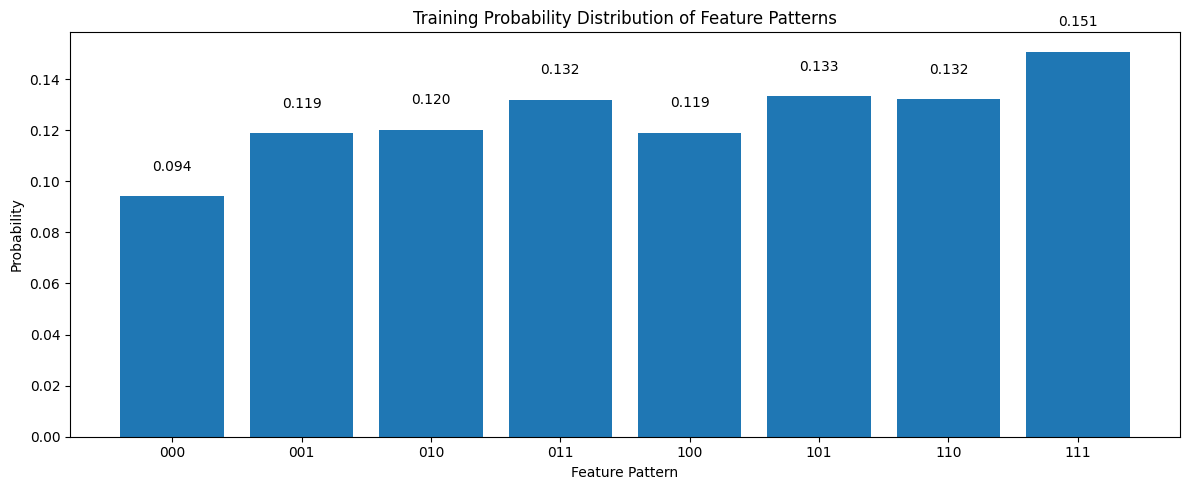


Probability distribution of output patterns:
--------------------------------------------------
Pattern    | Probability | Count
--------------------------------------------------
[0,0,0,0]  |      0.036 |   174
[0,0,0,1]  |      0.058 |   279
[0,0,1,0]  |      0.057 |   276
[0,0,1,1]  |      0.061 |   296
[0,1,0,0]  |      0.056 |   271
[0,1,0,1]  |      0.064 |   308
[0,1,1,0]  |      0.060 |   288
[0,1,1,1]  |      0.072 |   347
[1,0,0,0]  |      0.058 |   280
[1,0,0,1]  |      0.061 |   293
[1,0,1,0]  |      0.063 |   304
[1,0,1,1]  |      0.070 |   338
[1,1,0,0]  |      0.063 |   302
[1,1,0,1]  |      0.069 |   334
[1,1,1,0]  |      0.073 |   350
[1,1,1,1]  |      0.078 |   376

Total probability: 1.000000
Total samples: 4816


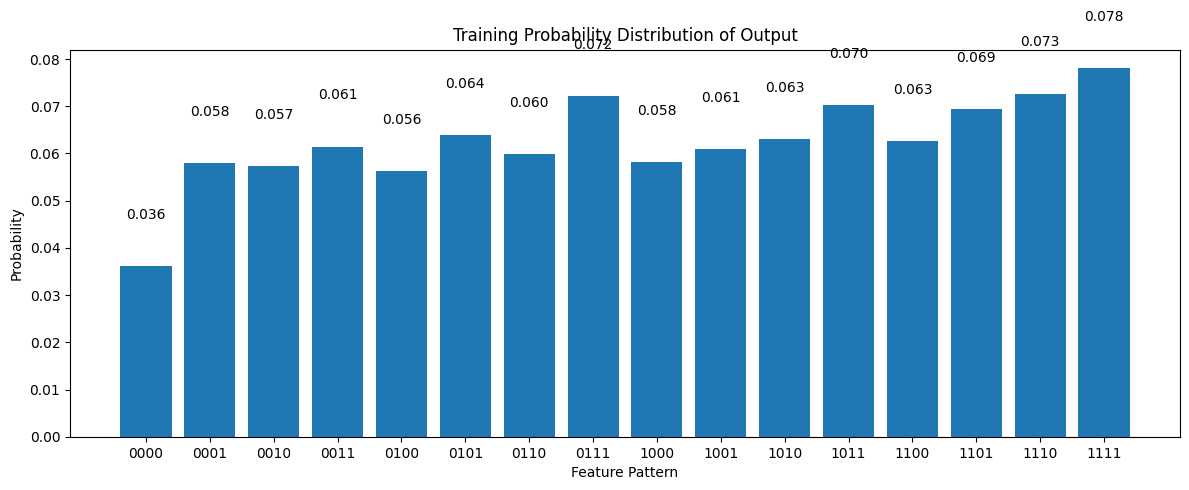

['00', '01', '10', '11']
<class 'pandas.core.series.Series'> context
0    0.3125
1    0.3125
2    0.3125
3    0.0625
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Distribution of Contexts')

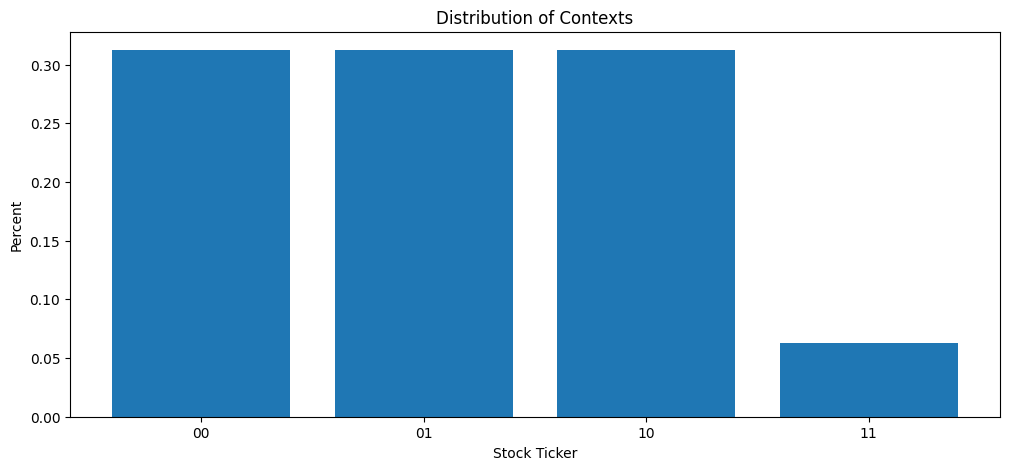

In [ ]:
# Analyze global probability distribution of feature patterns
from itertools import product
import matplotlib.pyplot as plt

# Get dimensions
n_features = WINDOW_SIZE - 1  # Should be 3
n_feat_patterns = 2**n_features  # 8 possible patterns for 3 binary features

# Generate all possible patterns in natural binary order
feat_patterns = np.array(list(product([0, 1], repeat=n_features)))
feat_pattern_strs = [''.join(map(str, p)) for p in feat_patterns]

# Stack all feature vectors into a 2D array
all_features = np.stack(df_train['window'].apply(lambda x: x[:WINDOW_SIZE-1]))

# Count occurrences of each pattern
feature_counts = np.zeros(n_feat_patterns)
for i, pattern in enumerate(feat_patterns):
    matches = np.all(all_features == pattern, axis=1)
    feature_counts[i] = np.sum(matches)

# Convert to probabilities
feature_probs = feature_counts / feature_counts.sum()

if VERBOSE:
    # Print probabilities in natural binary order
    print("\nProbability distribution of feature patterns:")
    print("-" * 50)
    print("Pattern    | Probability | Count")
    print("-" * 50)
    for i in range(n_feat_patterns):
        pattern_str = f"[{','.join(map(str, feat_patterns[i]))}]"
        print(f"{pattern_str:10s} | {feature_probs[i]:10.3f} | {int(feature_counts[i]):5d}")

# Verify distribution sums to 1
print(f"\nTotal probability: {feature_probs.sum():.6f}")
print(f"Total samples: {int(feature_counts.sum())}")

# Plot bar chart (keeping natural binary order)
plt.figure(figsize=(12, 5))
plt.bar(feat_pattern_strs, feature_probs)
plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Training Probability Distribution of Feature Patterns')

# Add probability values on top of bars
for i, v in enumerate(feature_probs):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

#Do the same thing but for target output probabilities
# Get dimensions
n_window = WINDOW_SIZE  # Should be 4
n_out_patterns = 2**n_window  # 16 possible patterns for 4 binary features

# Generate all possible patterns in natural binary order
out_patterns = np.array(list(product([0, 1], repeat=n_window)))
out_pattern_strs = [''.join(map(str, p)) for p in out_patterns]

# Stack all feature vectors into a 2D array
all_windows = np.stack(df_train['window'])

# Count occurrences of each pattern
window_counts = np.zeros(n_out_patterns)
for i, pattern in enumerate(out_patterns):
    matches = np.all(all_windows == pattern, axis=1)
    window_counts[i] = np.sum(matches)

# Convert to probabilities
output_probs = window_counts / window_counts.sum()

if VERBOSE:
    # Print probabilities in natural binary order
    print("\nProbability distribution of output patterns:")
    print("-" * 50)
    print("Pattern    | Probability | Count")
    print("-" * 50)
    for i in range(n_out_patterns):
        pattern_str = f"[{','.join(map(str, out_patterns[i]))}]"
        print(f"{pattern_str:10s} | {output_probs[i]:10.3f} | {int(window_counts[i]):5d}")

# Verify distribution sums to 1
print(f"\nTotal probability: {output_probs.sum():.6f}")
print(f"Total samples: {int(window_counts.sum())}")

# Plot bar chart (keeping natural binary order)
plt.figure(figsize=(12, 5))
plt.bar(out_pattern_strs, output_probs)
plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Training Probability Distribution of Output')

# Add probability values on top of bars
for i, v in enumerate(output_probs):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# get context distribution
n_context = np.log2(df_returns.shape[1]).astype(int)

context_states = np.array(list(product([0, 1], repeat=n_context)))
context_states = [''.join(map(str, p)) for p in context_states]

context_dist = df_train['context'].value_counts(normalize=True).sort_index()
plt.figure(figsize=(12,5))
plt.bar(context_states, context_dist)
plt.ylabel('Percent')
plt.xlabel('Stock Ticker')
plt.title('Distribution of Contexts')

## Create state-preparation circuit to load input probability distribution into an approximate quantum state

In [15]:
# State preparation circuit (hardware-efficient ansatz)
import pennylane as qml

L_SP = 2 # number of layers for state preparation ansatz
N_WIRES_SP = WINDOW_SIZE - 1  # 3 qubits for 3 features

dev_sp = qml.device("default.qubit", wires=N_WIRES_SP)

def hardware_efficient_ansatz(params, n_wires=N_WIRES_SP):
    #Hadamard layer
    for i in range(n_wires):
        qml.Hadamard(wires=i)

    #Optimization layers
    for l in range(L_SP):
        for i in range(n_wires):
            qml.RY(params[l][i][0], wires=i)
            qml.RZ(params[l][i][1], wires=i)

        for j in range(n_wires):
            qml.CNOT(wires=[j, (j + 1) % n_wires])

@qml.qnode(dev_sp, interface='torch', diff_method='spsa')
def sp_circuit(params):

    hardware_efficient_ansatz(params)

    return qml.probs(wires=range(N_WIRES_SP))

Starting SPSA training for state preparation...
Epoch 10/100 - MSE Loss: 0.000647
Epoch 20/100 - MSE Loss: 0.000254
Epoch 30/100 - MSE Loss: 0.000380
Epoch 40/100 - MSE Loss: 0.000327
Epoch 50/100 - MSE Loss: 0.000183
Epoch 60/100 - MSE Loss: 0.000353
Epoch 70/100 - MSE Loss: 0.000508
Epoch 80/100 - MSE Loss: 0.000365
Epoch 90/100 - MSE Loss: 0.004159
Epoch 100/100 - MSE Loss: 0.000875
Final state preparation parameters: 
Parameter containing:
tensor([[[-2.1134e-01, -8.9754e-01],
         [ 1.5025e-01, -1.4862e+00],
         [-2.5913e-02,  8.1389e-01]],

        [[ 1.9039e-01,  1.8004e+00],
         [ 4.4980e-01,  1.3831e+00],
         [ 4.1052e-04,  3.0574e+00]]], requires_grad=True)

Target probs:
 [0.094061 0.118771 0.120224 0.131852 0.118978 0.133306 0.13206  0.150748]
Final prepared probs:
 [0.102217 0.155233 0.097859 0.123857 0.076909 0.096598 0.150724 0.196603]
[0.00017707544391356396, 0.0009074143114779315, 0.0018237137215378198, 0.0013618595872732465, 0.0007960032531065072, 0.

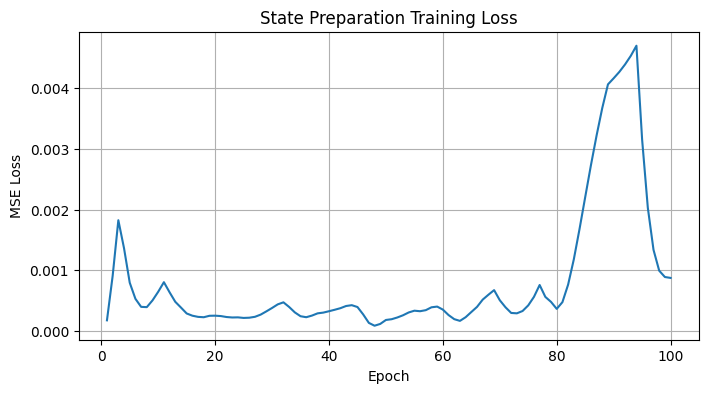

In [ ]:
# Train the hardware-efficient ansatz to prepare the target probability distribution using PennyLane's SPSA optimizer
import torch
import torch.nn as nn

N_EPOCHS_SP = 100
LEARNING_RATE_SP = 0.1
INIT_PARAM_SCALE = 0.01

target_probs = torch.tensor(feature_probs, dtype=torch.float64)

# Initialize parameters as a NumPy array
params_sp = nn.Parameter(torch.randn(L_SP, N_WIRES_SP, 2) * INIT_PARAM_SCALE)

# Create SPSA optimizer
opt_sp = torch.optim.Adam([params_sp], lr=LEARNING_RATE_SP)

loss_fn_sp = nn.MSELoss()

# Training loop using SPSA optimizer
print("Starting SPSA training for state preparation...")
losses_sp = []

for epoch in range(N_EPOCHS_SP):
    # Single SPSA update step

    y_pred = sp_circuit(params_sp)

    #print('y_pred:', y_pred)

    loss = loss_fn_sp(y_pred, target_probs)

    loss.backward()

    opt_sp.step()

    opt_sp.zero_grad()

    losses_sp.append(loss.item())
    
    # Print progress
    if (epoch + 1) % max(1, (N_EPOCHS_SP // 10)) == 0 or epoch == N_EPOCHS_SP - 1:
        print(f"Epoch {epoch+1}/{N_EPOCHS_SP} - MSE Loss: {loss:.6f}")

# Get final distribution
final_out = sp_circuit(params_sp)

# Detach from autograd graph for final printing/plotting
final_out_np = final_out.detach().numpy()
target_out_np = target_probs.detach().numpy()

print("Final state preparation parameters: ")
print(params_sp)

print("\nTarget probs:\n", np.round(target_out_np, 6))
print("Final prepared probs:\n", np.round(final_out_np, 6))

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(losses_sp) + 1), losses_sp)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('State Preparation Training Loss')
plt.grid(True)
plt.show()

[0.09406146 0.11877076 0.12022425 0.13185216 0.11897841 0.13330565
 0.1320598  0.15074751]
[0.1022174  0.15523325 0.09785883 0.12385671 0.07690928 0.09659806
 0.15072381 0.19660266]


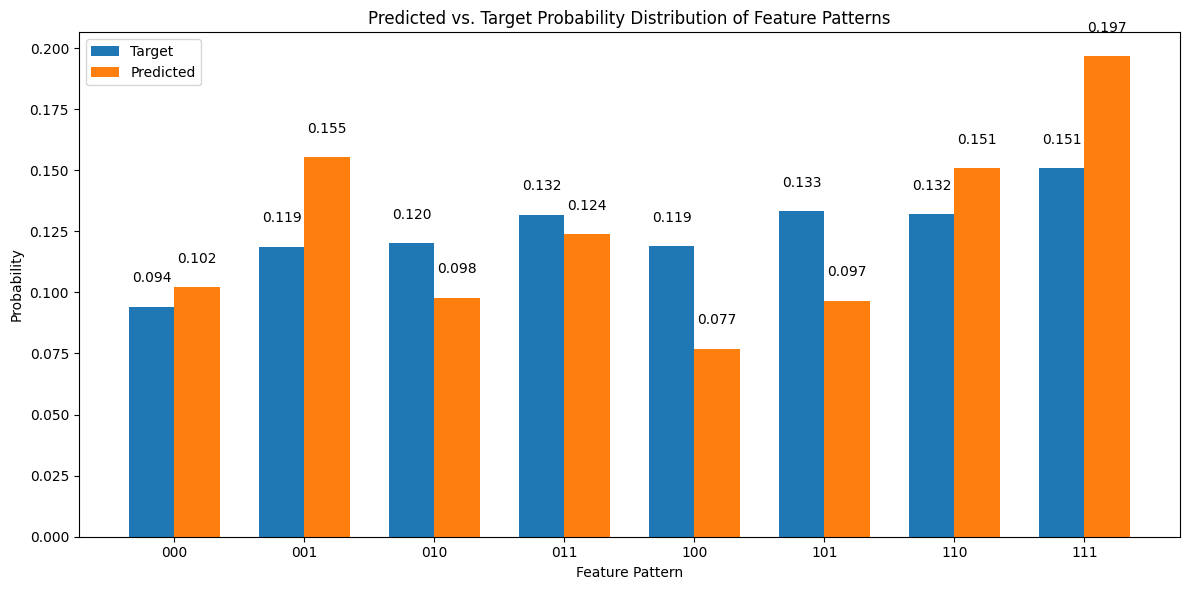

In [21]:
#Plot target probabilities and predicted probabilites
x = np.arange(len(feat_pattern_strs))
width = 0.35  # Width of the bars

print(target_out_np)
print(final_out_np)

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, target_out_np, width, label='Target')
plt.bar(x + width/2, final_out_np, width, label='Predicted')

plt.ylabel('Probability')
plt.xlabel('Feature Pattern')
plt.title('Predicted vs. Target Probability Distribution of Feature Patterns')
plt.xticks(x, feat_pattern_strs)
plt.legend()

# Add probability values on top of bars
for i, (v1, v2) in enumerate(zip(target_out_np, final_out_np)):
    plt.text(i - width/2, v1 + 0.01, f'{v1:.3f}', ha='center')
    plt.text(i + width/2, v2 + 0.01, f'{v2:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Create Prediction Circuit (Quantum Multi-Task Learning)

In [30]:
#Build the circuit

# 0-1: context qubits
# 2-4: input qubits
# 5: output qubit
N_CONTEXT_WIRES = n_context  # Number of qubits needed to represent stocks
N_OUTPUT_WIRES = int(np.log2(N_BINS))
N_INPUT_WIRES = WINDOW_SIZE - N_OUTPUT_WIRES
N_TARGET_WIRES = N_INPUT_WIRES + N_OUTPUT_WIRES
N_TOTAL_WIRES = N_CONTEXT_WIRES + N_INPUT_WIRES + N_OUTPUT_WIRES + N_TARGET_WIRES + 1 #ancillary qubit

N_LAYERS = 2

LEARNING_RATE = 0.01
N_EPOCHS = 10

input_wires = list(range(N_INPUT_WIRES))
output_wires = list(range(N_INPUT_WIRES, N_INPUT_WIRES + N_OUTPUT_WIRES))
context_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES, N_INPUT_WIRES + N_OUTPUT_WIRES + N_CONTEXT_WIRES))
target_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES + N_CONTEXT_WIRES, N_TOTAL_WIRES - 1))
ancillary_wire = N_TOTAL_WIRES - 1
comp_wires = list(range(N_INPUT_WIRES + N_OUTPUT_WIRES))

# Define device using simulator for training
dev = qml.device("default.qubit", wires=N_TOTAL_WIRES)

def context_state_prep(wires):
    #Prepare context qubit state using percentages of each stock
    context_vect = np.array(np.sqrt(context_dist), dtype=complex)

    qml.StatePrep(context_vect, wires=wires)

def target_state_prep(wires):
    #Prepare target state using target output probability distribution
    output_vect = np.array(np.sqrt(output_probs), dtype=complex)

    qml.StatePrep(output_vect, wires=wires)

# layer for both either the shared or specify ansatz (input is just trainable parameters)
def U_ss(params):
    """A single (L=1) ansatz layer (Rotations + CNOTs)."""
    # 1. Trainable Rotations
    for i, wire in enumerate(comp_wires):
        qml.RY(params[i][0], wires=wire)
        qml.RZ(params[i][1], wires=wire)
    
    # 2. Entangling "Ring"
    for i in range(len(comp_wires)):
        qml.CNOT(wires=[comp_wires[i], comp_wires[(i + 1) % len(comp_wires)]])

def SWAP_test():
    qml.Hadamard(wires=ancillary_wire)

    for i in range(N_TARGET_WIRES):
        # CSWAP gate
        qml.CSWAP(wires=[ancillary_wire, comp_wires[i], target_wires[i]])
    
    qml.Hadamard(wires=ancillary_wire)

@qml.qnode(dev, interface='torch', diff_method='spsa')
def qmtl_circuit(params): # context is a classical input for now (what a drag...)
    
    # Approximate input state preparation
    hardware_efficient_ansatz(params_sp, N_INPUT_WIRES)

    #Exact target state preparation
    target_state_prep(target_wires)

    #Exact context state preparation
    context_state_prep(context_wires)

    #Implement shared variational layers
    for l in range(N_LAYERS):
        U_ss(params['shared'][l])

    # Implement control gates for specify layers
    for l in range(N_LAYERS):
        for context in context_states:
            qml.ctrl(lambda: U_ss(params['spec'][context][l]), control=context_wires, control_values=context)

    # perform SWAP test
    SWAP_test()

    # Measure fidelity (1 - P(0) in ancillary qubit)
    return qml.probs(ancillary_wire)



--- Starting Training ---
Epoch 1/100 - Loss: 0.4926
Epoch 2/100 - Loss: 0.4923
Epoch 3/100 - Loss: 0.4922
Epoch 4/100 - Loss: 0.4915
Epoch 5/100 - Loss: 0.4909
Epoch 6/100 - Loss: 0.4904
Epoch 7/100 - Loss: 0.4900
Epoch 8/100 - Loss: 0.4897
Epoch 9/100 - Loss: 0.4893
Epoch 10/100 - Loss: 0.4888
Epoch 11/100 - Loss: 0.4883
Epoch 12/100 - Loss: 0.4877
Epoch 13/100 - Loss: 0.4873
Epoch 14/100 - Loss: 0.4869
Epoch 15/100 - Loss: 0.4865
Epoch 16/100 - Loss: 0.4861
Epoch 17/100 - Loss: 0.4857
Epoch 18/100 - Loss: 0.4853
Epoch 19/100 - Loss: 0.4850
Epoch 20/100 - Loss: 0.4847
Epoch 21/100 - Loss: 0.4843
Epoch 22/100 - Loss: 0.4836
Epoch 23/100 - Loss: 0.4829
Epoch 24/100 - Loss: 0.4822
Epoch 25/100 - Loss: 0.4816
Epoch 26/100 - Loss: 0.4811
Epoch 27/100 - Loss: 0.4806
Epoch 28/100 - Loss: 0.4800
Epoch 29/100 - Loss: 0.4795
Epoch 30/100 - Loss: 0.4790
Epoch 31/100 - Loss: 0.4785
Epoch 32/100 - Loss: 0.4780
Epoch 33/100 - Loss: 0.4775
Epoch 34/100 - Loss: 0.4771
Epoch 35/100 - Loss: 0.4767
Ep

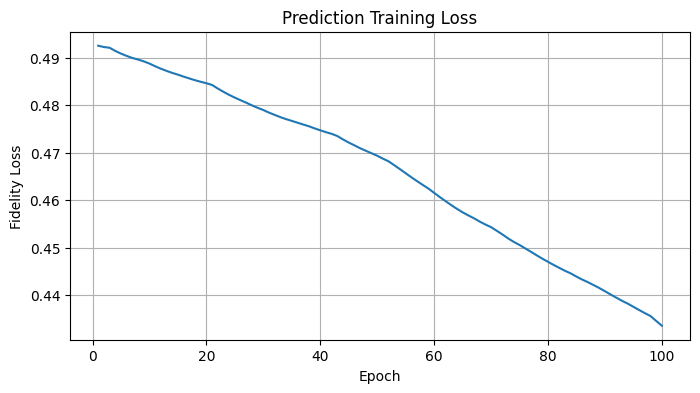

In [ ]:
#Train prediction circuit

import torch
import torch.nn as nn

LEARNING_RATE = 0.01
N_EPOCHS = 1000

def init_params():
    """
    Initialize the trainable parameters using torch.nn.Parameter
    """
    n_params_per_layer = len(comp_wires) # 3 input + 1 output = 4
    
    # --- Shared Parameters ---
    # We need L=2 layers of 4 params each
    shared_params = torch.randn(N_LAYERS, n_params_per_layer, 2, requires_grad=True)
    
    # --- Specify Parameters ---
    # We need K=4 sets of (L=2 layers * 4 params each)
    n_stocks = 2**N_CONTEXT_WIRES
    spec_params = torch.randn(n_stocks, N_LAYERS, n_params_per_layer, 2, requires_grad=True)
    
    # We use torch.nn.ParameterDict to keep them organized
    return nn.ParameterDict({
        "shared": nn.Parameter(shared_params),
        "spec": nn.Parameter(spec_params)
    })

#Train the circuit
params = init_params()

optimizer = torch.optim.Adam(params.values(), lr=LEARNING_RATE)

def fidelity_loss(params):
    # Run circuit
    y_pred = qmtl_circuit(params)

    return 1 - y_pred[0]  # Fidelity loss: 1 - P(0)

print("\n--- Starting Training ---")
    # --- Run Epochs ---
loss_hist = []
for epoch in range(N_EPOCHS):
    total_loss = 0
    
    # Do Quantum Batch Gradient Update (QBGU)
    loss = fidelity_loss(params)
    
    # Calculate Gradients
    # PyTorch and PennyLane work together to run the parameter-shift rule for ALL parameters.
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Clear gradients
    optimizer.zero_grad()
    
    loss_hist.append(loss.item())

    print(f"Epoch {epoch+1}/{N_EPOCHS} - Loss: {loss:.4f}")

print("--- Training Complete ---")
print("Final Parameters (Shared):")
print(params['shared'])
print("Final Parameters (Specify):")
print(params['spec'])

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(loss_hist) + 1), loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Fidelity Loss')
plt.title('Prediction Training Loss')
plt.grid(True)
plt.show()

In [ ]:
#Plot the final circuit

# 0: Input 1
# 1: Input 2
# 2: Input 3
# 3: Output
# 4: Context 1
# 5: Context 2
# 6: Target 1
# 7: Target 2
# 8: Target 3
# 9: Target 4 (output)
# 10: Ancillary

print(qml.draw(qmtl_circuit)(params))

 0: ──H──────────RY(-0.21)──RZ(-0.90)─╭●────╭X──RY(0.19)──RZ(1.80)─╭●────╭X──RY(-1.17) ···
 1: ──H──────────RY(0.15)───RZ(-1.49)─╰X─╭●─│───RY(0.45)──RZ(1.38)─╰X─╭●─│───RY(-1.64) ···
 2: ──H──────────RY(-0.03)──RZ(0.81)─────╰X─╰●──RY(0.00)──RZ(3.06)────╰X─╰●──RY(1.13)─ ···
 3: ──RY(-0.02)──RZ(1.46)───────────────────────────────────────────────────────────── ···
 4: ─╭|Ψ⟩───────────────────────────────────────────────────────────────────────────── ···
 5: ─╰|Ψ⟩───────────────────────────────────────────────────────────────────────────── ···
 6: ─╭|Ψ⟩───────────────────────────────────────────────────────────────────────────── ···
 7: ─├|Ψ⟩───────────────────────────────────────────────────────────────────────────── ···
 8: ─├|Ψ⟩───────────────────────────────────────────────────────────────────────────── ···
 9: ─╰|Ψ⟩───────────────────────────────────────────────────────────────────────────── ···
10: ──H─────────────────────────────────────────────────────────────────────────────── ···